Metadata:



The dataset consists of feature vectors belonging to 12,330 sessions.
The dataset was formed so that each session
would belong to a different user in a 1-year period to avoid
any tendency to a specific campaign, special day, user
profile, or period.
    
    "Administrative", "Administrative Duration", "Informational", "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction. The "Special Day" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

In [1]:
#Al parecer el dataset ha sido creado siguiendo métodos probabilísticos y lo trataremos así.

In [2]:
!pip install scikeras

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scikitplot.metrics import plot_roc, plot_cumulative_gain
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasClassifier

%matplotlib inline

In [4]:
#Cargamos el dataset

data=pd.read_csv(r'C:\Users\gshoc\OneDrive\Documentos\MASTER\MODULE 6\EVALUACIÓN FINAL\online_shoppers_intention.csv')

In [5]:
#We will define some functions which will be helpful later

def categorical_analysis(var, **kwargs):
    fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title(f'Variable {var}')
    sns.countplot(data=data, x=var, **kwargs, ax=axes[0])
    crossed=pd.crosstab(data[var], data.Revenue, normalize=0).unstack().reset_index().rename(columns={0:'Percentage'})
    crossed.loc[crossed.Revenue==False,'Percentage']=1
    sns.barplot(data=crossed, x=var, y='Percentage', hue='Revenue', ax=axes[1], **kwargs, dodge=False)
    axes[1].set_title(f'Revenue ~ {var}')
    plt.suptitle(f'Variable {var}')
    plt.show()   
    print('\n CHI SQUARE TEST \n')
    p_value=chi2_contingency(pd.crosstab(data[var], data.Revenue))[1]
    if p_value>0.05:
        print(f'The p_value is {p_value} and therefore we have to accept the null hypothesis that there is no significant relationship between {var} and Revenue')
    else:
        print(f'The p_value is {p_value} and therefore we can reject the null hypothesis that there is no significant relationship between {var} and Revenue')
        
        
def continuous_analysis(var,data=data, **kwargs):
    fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].set_title(f'Variable {var}')
    sns.histplot(data, x=var, **kwargs, ax=axes[0], bins=30, hue='Revenue', multiple='stack')
    sns.boxplot(data=data,y=var,x='Revenue', hue='Revenue' , ax=axes[1], **kwargs)
    plt.title(f'Revenue ~ {var}')
    plt.suptitle(f'Variable {var}')
    plt.show()
    print(f'\n The maximum value is {data[var].max()} \n The minimum value is {data[var].min()} ')
    

In [6]:
#Miramos las primeras observaciones

data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
#Comprobamos la estructura de los datos

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [8]:
#Valores nulos:

data.isnull().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [9]:
#Eliminamos filas con valores nulos (según estipulado en el ejecicio) Nos son muchas.

data=data.dropna().copy()

In [10]:
#Ya sabemos de la metadata proporcionada en la página de UCI (de allí proviene el dataset) que algunas variables son categoricas 
#aunque aparezquen como numericas ahora.

#También podemos comprobar el número de valores distintos por variable lo que nos ayudaria detectar candidatos a categoricas.

print(data.nunique())

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64


In [11]:
#Las primeras 10 variables son numericas - contabilizan diferentes metricas relacionadas a lás páginas.
#Las siguientes variables son categoricas.Vamos a convertirlas.

cat=data.columns[10:]

data[cat]=data[cat].astype('category')

In [12]:
#análisis estadístico inicial

data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.895952,0.061497
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.577926,0.199020
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


In [13]:
#Ya podemos apreciar que las medias son mucho mas cercanas a los mínimos que a los máximos que nos prepara para el hecho que las 
#distribuciones no sean normales. 

#Los máximos son muy alejados del tecer cuartil en muchas variables - habrá outliers.

#Tambien tenemos valor negativo como mínimo en varias variables relacionadas a tiempo - lo que no tiene sentido aparentemente.
#Comprobaremos esto con las gráficas.


data.describe(include='category')

,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12316,12316,12316,12316,12316,12316,12316,12316
unique,10,8,13,9,20,3,2,2
top,May,2,2,1,2,Returning_Visitor,False,False
freq,3363,6593,7951,4774,3909,10537,9451,10408


In [14]:
#Podemos apreciar que las variables categoricas son no balanceadas. Especialmente se lo puede deicr sobre la variable target:

data.Revenue.value_counts()

False    10408
True      1908
Name: Revenue, dtype: int64

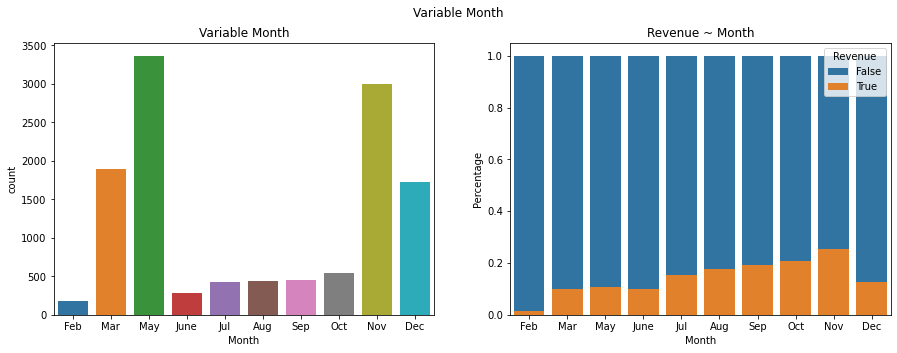


 CHI SQUARE TEST 

The p_value is 5.46332198852918e-77 and therefore we can reject the null hypothesis that there is no significant relationship between Month and Revenue


In [15]:
#Analizaremos las variables categoricas análisis univariante y bivariante con el target. 



categorical_analysis('Month', order=['Feb','Mar','May','June','Jul','Aug','Sep','Oct','Nov','Dec'], palette='tab10')

In [16]:
#Podemos tener varias conclusiones:

#1.Los datos no están distribuidos de modo equilibrado durante los meses del año. Esto puede ser resultado de 
#manera de construcción del dataset o mostrar tendencias reales (aunque las diferencias no son probables si no hay otro factor)

#2. La conversión (Las visitas que acaban con compra) es diferente entre los meses y podemos ver tendencia general positiva entre 
#febrero a noviembre en tasa de conversión. (meses Marzo, Mayo, Junio tienen más o menós la misma conversión).

#3. Nos faltan datos para enero y abril.

#4 El chi-square test que comprueba el magnitud de relación entre la variable independiente y Revenue es significativo.



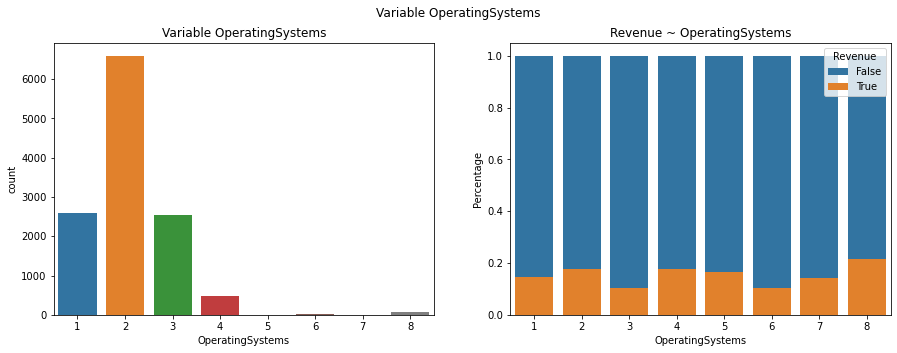


 CHI SQUARE TEST 

The p_value is 1.425746500475422e-13 and therefore we can reject the null hypothesis that there is no significant relationship between OperatingSystems and Revenue


In [17]:
categorical_analysis('OperatingSystems')

In [18]:
#Podemos ver que las categorias de Operating systems no son balanceadas. Aunque el chi test es significativo, podemos tener 
#problema con categorias minoriatarias :

data.OperatingSystems.value_counts()

2    6593
1    2582
3    2552
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

In [19]:
#Categorias con pocas observaciones pueden no representar bien la realidad por que cada observación en ellas obtiene mucho peso.
#Uniremos categorias 6-7-5 en una:

data.loc[:,'OperatingSystems']=data.OperatingSystems.replace({5:'Other',6:'Other',7:'Other'})

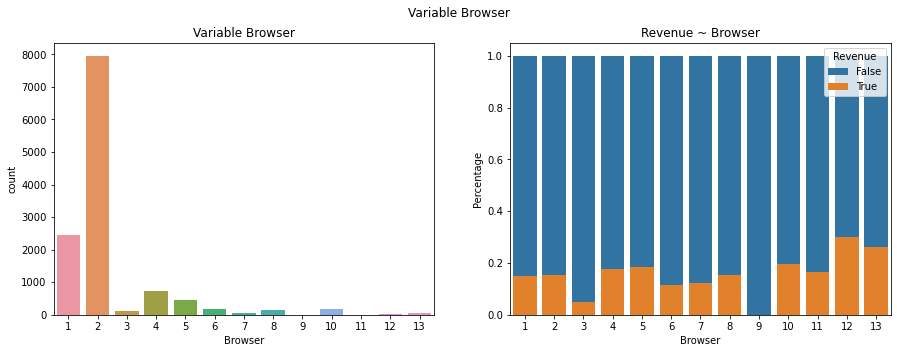


 CHI SQUARE TEST 

The p_value is 0.006172783021813588 and therefore we can reject the null hypothesis that there is no significant relationship between Browser and Revenue


In [20]:
categorical_analysis('Browser')

In [21]:
data.Browser.value_counts()

2     7951
1     2459
4      735
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: Browser, dtype: int64

In [22]:
#El problema anterior de categorias minoritarias posiblemente no representativas podemos ver aquí también. Po ejemplo Browser 9
#no tiene conversión pero si cuantificamos el número de casos de esta categoria vemos que tiene solo 1. Uniremos las categorias 
#7,12,11,9 en una.

data['Browser']=pd.Series(np.where(data.Browser.isin([7,12,11,9]), 'Other', data.Browser)).astype('category')

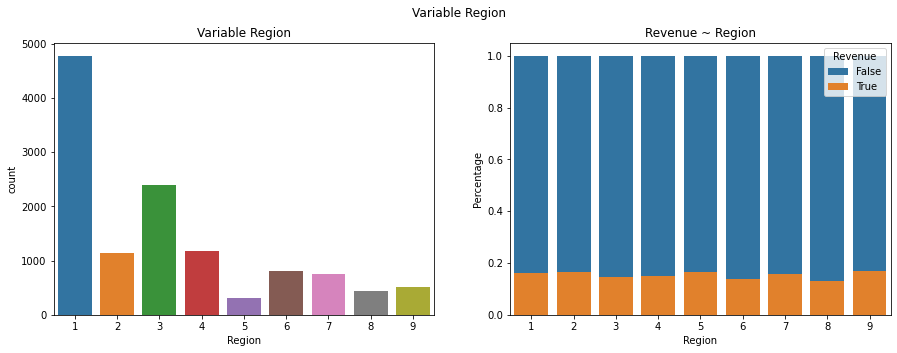


 CHI SQUARE TEST 

The p_value is 0.31672455599447547 and therefore we have to accept the null hypothesis that there is no significant relationship between Region and Revenue


In [23]:
categorical_analysis('Region')

In [24]:
#No hay mucha diferencia entre las categorias en analísis bivariante y también el chi-square test nos lo dice 
#(está variable no es relacionada a Revenue estadísticamente). La conclusíon qye esta variable no sería buen predictor 
#de revenue.

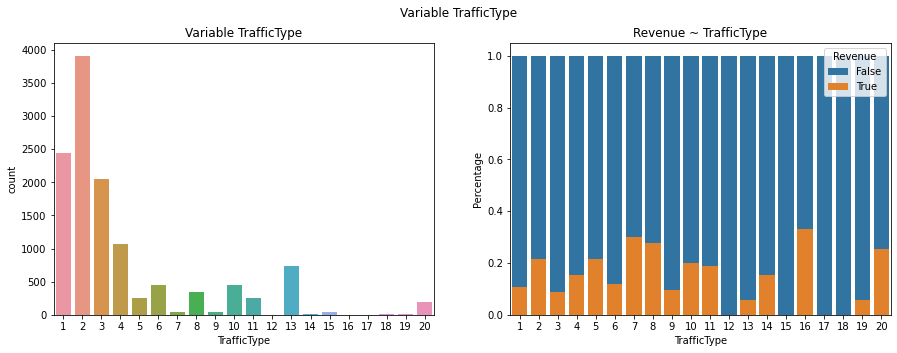


 CHI SQUARE TEST 

The p_value is 2.397356014360425e-67 and therefore we can reject the null hypothesis that there is no significant relationship between TrafficType and Revenue


In [25]:
categorical_analysis('TrafficType')

In [26]:
#En general la variable parece ser buena predictor pero aun tenemos que tratar categorias minoritarias que no 
#presentan información estadisticamente representativa.

data.TrafficType.value_counts()

2     3909
1     2444
3     2051
4     1069
13     737
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      37
19      17
14      13
18      10
16       3
12       1
17       1
Name: TrafficType, dtype: int64

In [27]:
#Vamos pasar lac categorias de menos de 50 observaciones a una.

index=data.TrafficType.value_counts()[data.TrafficType.value_counts()<50].index

data.loc[:,'TrafficType']=pd.Series(np.where(data.TrafficType.isin(index), 'Other', data.TrafficType)).astype('category')

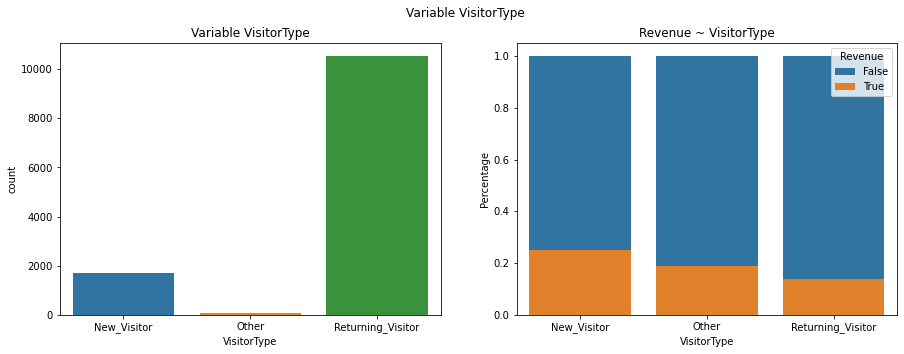


 CHI SQUARE TEST 

The p_value is 5.794232913061472e-30 and therefore we can reject the null hypothesis that there is no significant relationship between VisitorType and Revenue


Returning_Visitor    10537
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [28]:
categorical_analysis('VisitorType')

data.VisitorType.value_counts() 

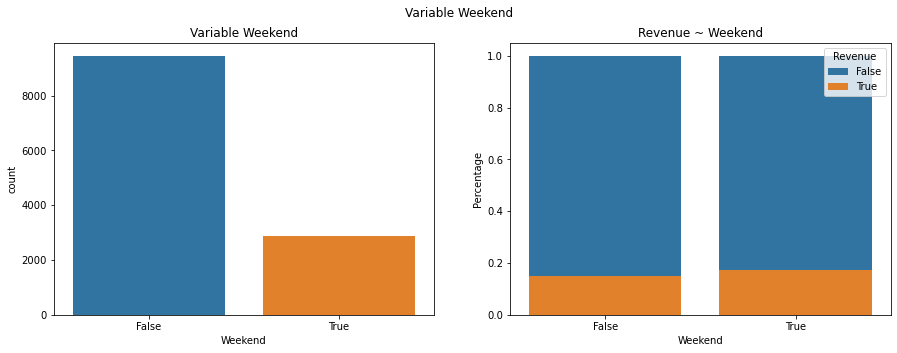


 CHI SQUARE TEST 

The p_value is 0.001275672061116591 and therefore we can reject the null hypothesis that there is no significant relationship between Weekend and Revenue


False    9451
True     2865
Name: Weekend, dtype: int64

In [29]:
#Variable no balanceada pero parece que hay diferencia en coonversión entre categorias. Dejaremos 'Other' intacta.

categorical_analysis('Weekend')

data.Weekend.value_counts() 

In [30]:
#La categoria de 'No weekend' es mas grande, lo que puede ser atribuido al hecho que cinco de los 7 días de la semana no son
#weekend. Sí existe diferencia pequeña en la tasa de conversión y el chi-test la detecta como significativa. Conclusión: 
#Hay relación entre las variables.

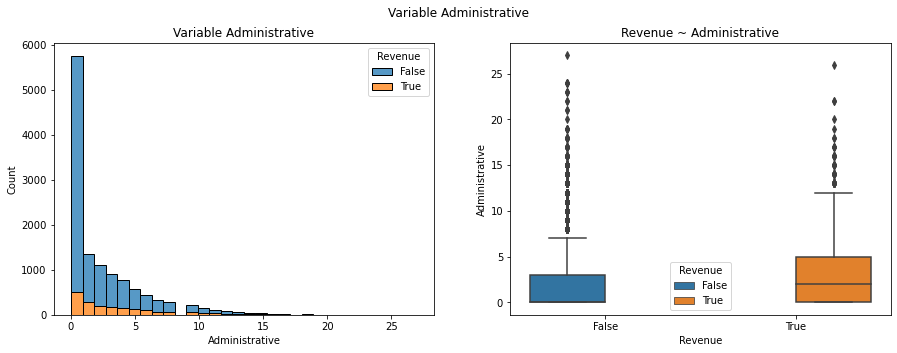


 The maximum value is 27.0 
 The minimum value is 0.0 


In [31]:
#Empezamos con variables nuuméricas:

continuous_analysis('Administrative')

In [32]:
#La distribución no es normal. Sobre la mitad de sesiones no tenían visitas a páginas administrativas. La sesiones terminadas 
#en conversion (Revenue True) tienen considerablemente más visitas a páginas administrativas.

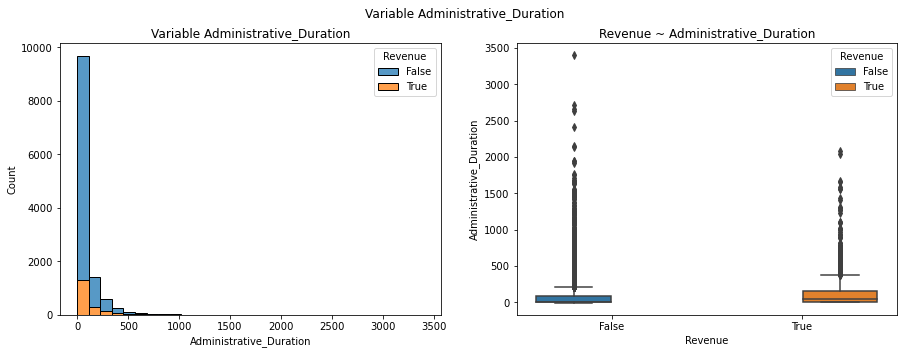


 The maximum value is 3398.75 
 The minimum value is -1.0 


In [33]:
continuous_analysis('Administrative_Duration')

In [34]:
#Tenemos valores negativos en duración lo que no es correcto - duración no puede ser negativa. Vamos a ver cuántos casos tenemos.

print(f'Number of observations with negative duration: {len(data[data.Administrative_Duration<0])}')

data[data.Administrative_Duration<0].head()

#Tenemos 33 observaciones con valores negativos. Lo más probable que las observaciones que tienen valor 0 en variable 
#'Administrativo' tienen que tener 0 en la duración y así vamos a imputar.Pero vemos que en otros campos de duración 
#tambien hay valores negativos. Como son solo 33 observaciones, constituyen 0.003 del dataset. Tenemos suficientes datos sin
#estos observaciones y los vamos a eliminar

Number of observations with negative duration: 33


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
2,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
6,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
16,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0,Feb,1,1,4,3,Returning_Visitor,False,False
21,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.2,0.2,0.0,0.0,Feb,3,3,1,3,Returning_Visitor,False,False


In [35]:
data=data.drop(data[(data.Administrative_Duration<0)&(data.Informational_Duration<0)&(data.ProductRelated_Duration<0)].index).reset_index(drop=True)

In [36]:
#La duración de las sesiones puede llegar a valores de más de 3000 que de primera vista puede parecer erroneo pero si 
#investigamos más entendemos que se trata de segundos en Google analytics y que sí puede demostrar realidad (por ejemplo cuando
#la sesión es inactiva Google analytics sigue contando el tiempo - por defecto hasta media hora de inectividad pero puede ser ajustado.)



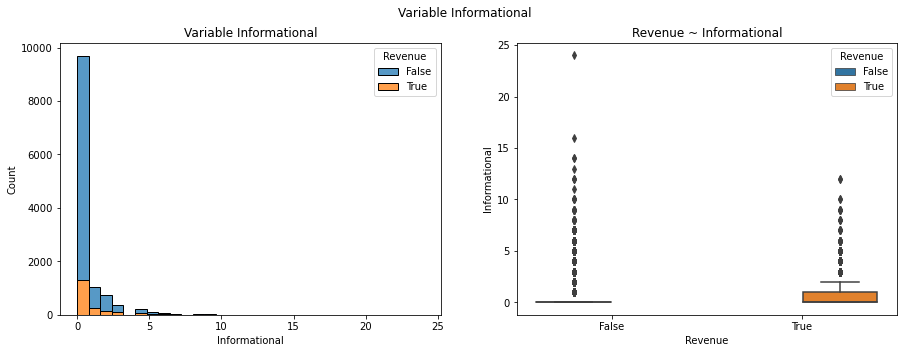


 The maximum value is 24.0 
 The minimum value is 0.0 


In [37]:
continuous_analysis('Informational')

In [38]:
#las sesiones con conversiones tienen más páginas informativas si consideramos el rango intercuartilico (segun lox boxplots).

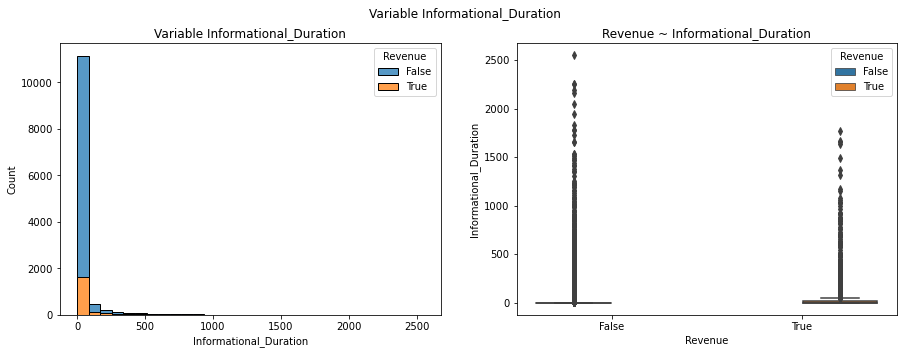


 The maximum value is 2549.375 
 The minimum value is 0.0 


In [39]:
continuous_analysis('Informational_Duration', data=data)

In [40]:
#Podemos observar el mismo problema - outliers muy altos. Como antes, puede ser explicado por sesiones inactivas.
#Tambien parece que esta variable y la anterior estan muy correlacionadas. Veremos más adelante si existe multicolinealidad.

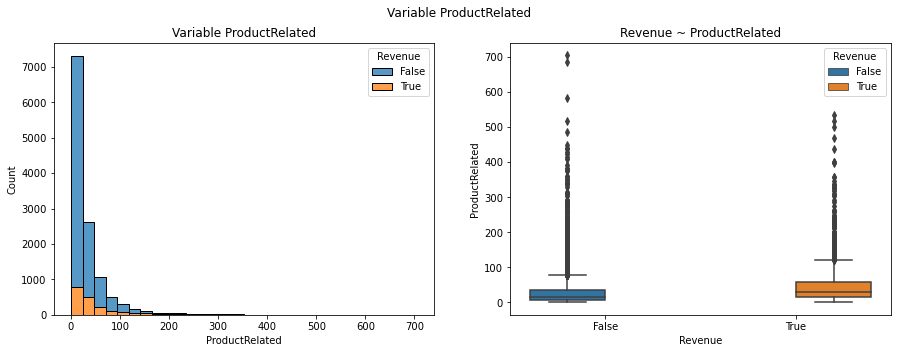


 The maximum value is 705.0 
 The minimum value is 0.0 


In [41]:
continuous_analysis('ProductRelated') 

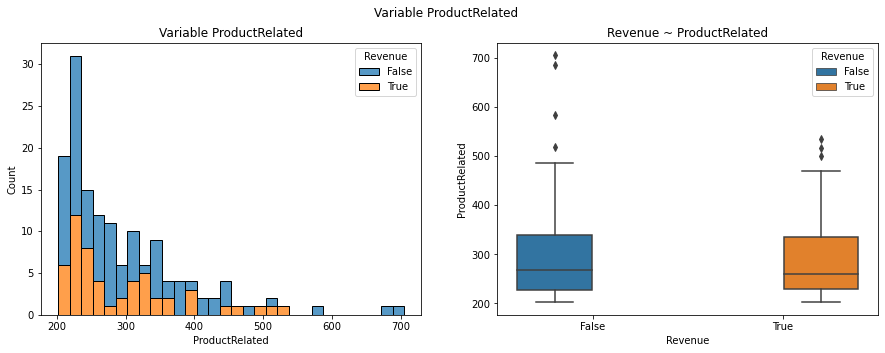


 The maximum value is 705.0 
 The minimum value is 202.0 


In [42]:
#Tenemos outliers muy inesperados. cientos de páginas relacionadas a productos en una sesión?
#Vamos comprobar la distribución de casos con más de 200 paginas.

continuous_analysis(data=data[data.ProductRelated>200], var='ProductRelated')

In [43]:
#Situación interesante en sesiones extremas, con muchas páginas vistas. Parece que las sesiones sin conversión tienen medianas 
#más altas de cantidad de páginas vistas. Buscaron un producto y no lo han encontrado?
#Esta tendencia es inversa a lo que pasa debajo de 200 páginas vistas.

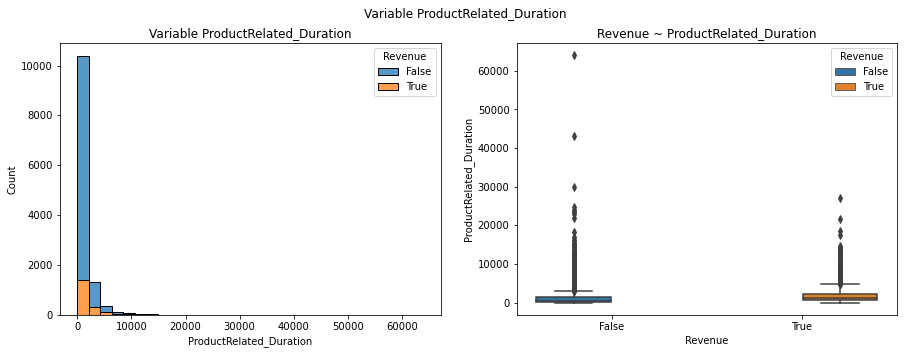


 The maximum value is 63973.52223 
 The minimum value is -1.0 


In [44]:
continuous_analysis('ProductRelated_Duration')

In [45]:
#Vemos valores muy altos. Pero sin conocer bien la materia (conocer el dominio y condiciones configuradas en analytics por la empresa 
#no borraria estos casos extrmos de outliers. Puede ser que son situaciones reales - sesiones no cerradas durante mucho tiempo.
#Tenemos que ser muy seguros para borrar o transformar oultliers.)

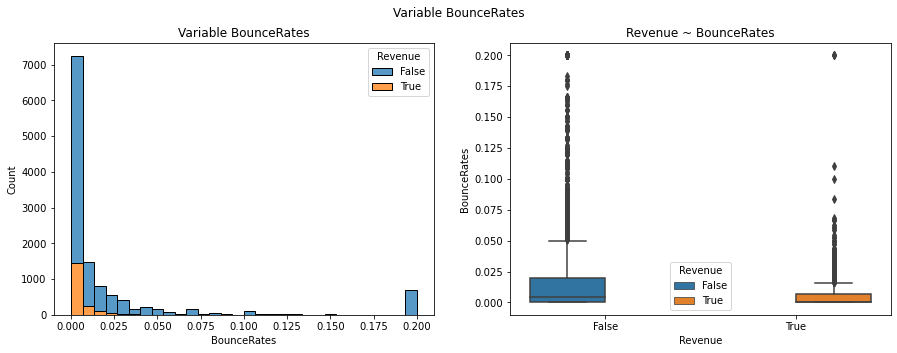


 The maximum value is 0.2 
 The minimum value is 0.0 


In [46]:
continuous_analysis('BounceRates')

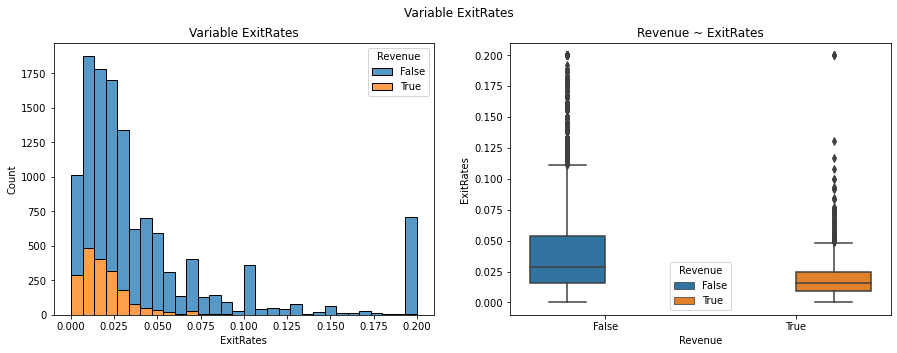


 The maximum value is 0.2 
 The minimum value is 0.0 


In [47]:
#Es sensato que habrá más conversiones dónde el landing page tiene 'bounce rate' más bajo.Es lo que vemos en el gráfico de boxplots.


continuous_analysis('ExitRates')

In [48]:
#Si entiendo bien, la metrica de 'Exit Rate' en este caso habla de media de 'ExitRates' de las páginas visitadas durante la
#sesión. Si es así, también hay sentido que páginas menos interesantes/populares/Exit Rate más alto tengan menos conversión.
#En otras palabras la gente que visita páginas con altas tasas de Exit Rate menos propensa de efectuar compras.

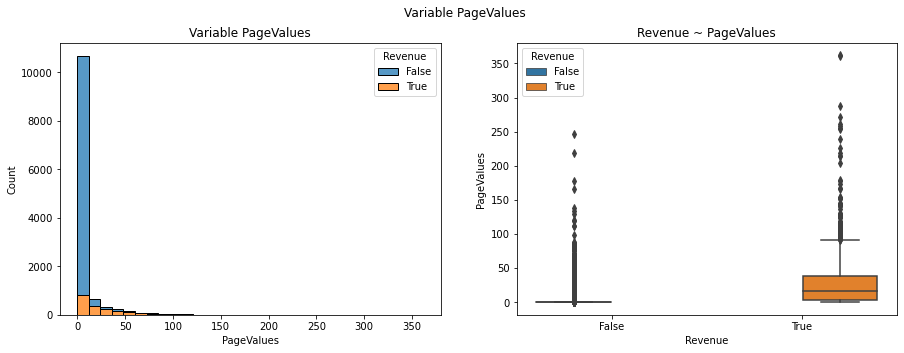


 The maximum value is 361.7637419 
 The minimum value is 0.0 


In [49]:
continuous_analysis('PageValues')

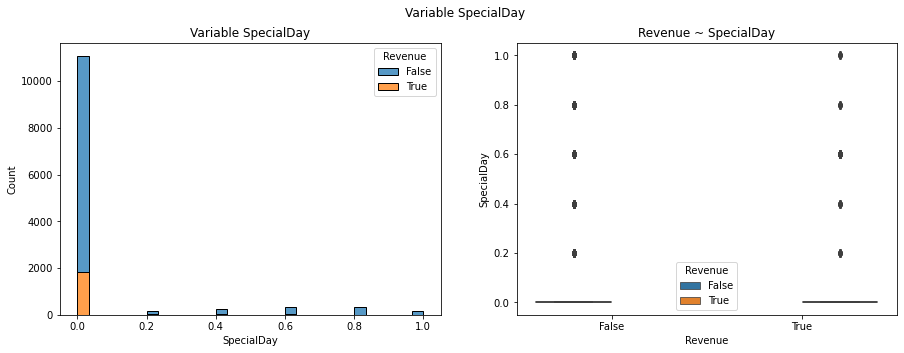


 The maximum value is 1.0 
 The minimum value is 0.0 


In [50]:
#Los valores más alto tienen que ser relacionadas con páginas de finalización del compra. Estas páginas suelen tener valores altos porque todas las conversiones 
#pasan por ellas página. Por ello vemos más conversión en sesiones con PageValues altos. Cómo explicamos los outliers sin conversión
#valores altos de PageValues? Probabllemente son aquellos que llegaron a páginas de finalización de compra pero terminaron
#el proceso y no lo finalizaron. Lo más probable que la variable 'PageValue' aquí refiere a la suma de 'PageValues' de las páginas visitadas.
#Si es así , la inclusión de páginas de finalización de compra no tiene mucha valor para predecir la conversión futura.
#Pero no sabemos de manera segura como contabilizaron la métrica PageValue para toda la sesion y consideraremos esta variable 
#par análisis final.

continuous_analysis('SpecialDay')


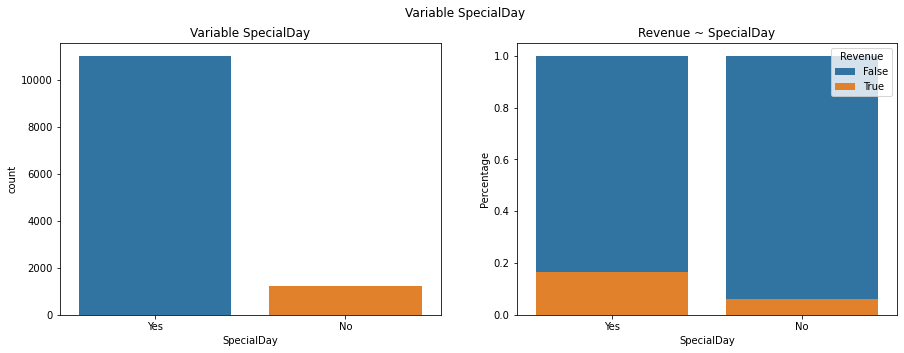


 CHI SQUARE TEST 

The p_value is 8.501710931936906e-22 and therefore we can reject the null hypothesis that there is no significant relationship between SpecialDay and Revenue


In [51]:
#Esta variable parece ser buena candidata a categoricas. Tiene solo 6 valores distintos (Lo hemos comprobado a principio).
#Vamos a dividirla en dos categorías: 'yes' para días de 'Special day' and 'no' para los demás(0.2-> 1)

data['SpecialDay']=pd.cut(data['SpecialDay'], bins=[-1,0.1,1.1], labels=['Yes','No'])

categorical_analysis('SpecialDay')

In [52]:
#Conclusiones -tenemos mucahs más observaciones de días especiales. Días especiales suelen tener conversión más alta y es 
#estadísticamente significativo.

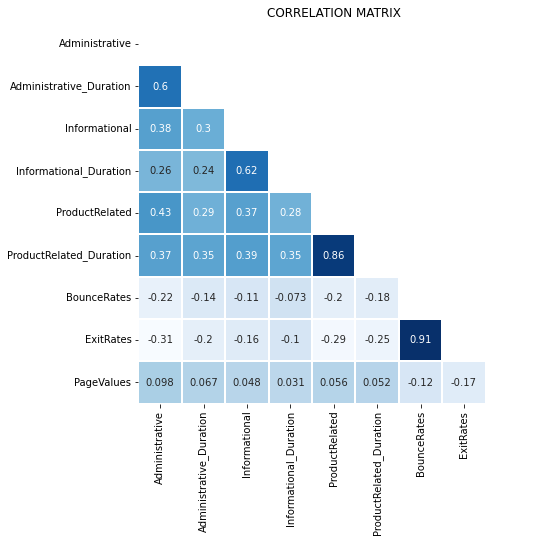

In [53]:
#Veremos la correlación entre variables independientes.

mask = np.triu(np.ones_like(data.corr()))
plt.figure(figsize=(7,7))
sns.heatmap(data.corr(), annot=True, mask=mask, cmap='Blues', xticklabels=data.select_dtypes(exclude='category').columns[:-1]\
           ,yticklabels='auto', linewidths=.1, cbar=False)
np.fill_diagonal(mask, True)
plt.title('CORRELATION MATRIX')
plt.show()

In [54]:
#Tenemos correlación alta en caso de 4 variables. Comprobaremos multicolinealidad.

numeric=data.select_dtypes(exclude='category')

VIF=pd.DataFrame()
VIF['variables']=numeric.columns
VIF['values']=[variance_inflation_factor(numeric.values, column) for column in range(len(numeric.columns))]
VIF

,variables,values
0,Administrative,2.651123
1,Administrative_Duration,2.041806
2,Informational,2.113786
3,Informational_Duration,1.777259
4,ProductRelated,6.309421
5,ProductRelated_Duration,6.007285
6,BounceRates,5.381302
7,ExitRates,5.614991
8,PageValues,1.077668


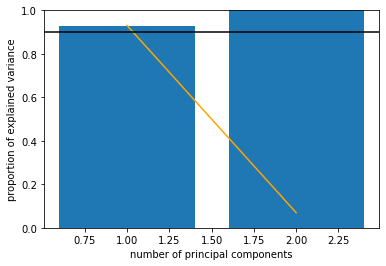

In [55]:
#Claramente tenemos problema con variables con valor de VIF más alto de 5. Pero también otras variables que miden el mismo concepto
#de manera poco diferente tienen correlación alta - 'administrative duration'/'administrative', 'Informational duration/informational'

#Tal vez podemos reducir el número de variables mediante análisis de compoonentes principales. Prevenir multicolineidad es buena
#práctica aunque no es necesaria para predicciones (sí para interpretación). Además queremos modelos cuanto más simples, con menos
#dimensiones.


#Primero escalamos los datos para prepararlos a PCA:
scaler=StandardScaler()
norm=pd.DataFrame()
norm[['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates']]\
=scaler.fit_transform(data[['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates']])

pca=PCA()
pca.fit(norm[['ProductRelated','ProductRelated_Duration',]])

#Representation of the accumulated explained variance.

plt.plot(range(1,3), pca.explained_variance_ratio_, c='orange')
plt.bar(range(1,3), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(f'number of principal components')
plt.ylabel(f'proportion of explained variance')
plt.ylim(0,1)
plt.axhline(0.9, c='black')
plt.show()

In [56]:
#Vemos que con una variable podemos explicar más de 90% de varianza de las dos variables originales.

pca=PCA(n_components=1)
norm['Product_Related_PCA']=pca.fit_transform(norm[['ProductRelated','ProductRelated_Duration']])

norm=norm.drop(['ProductRelated','ProductRelated_Duration'],axis=1)

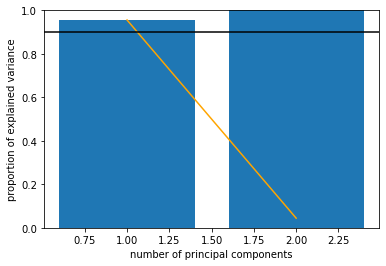

In [57]:
pca2=PCA()
pca2.fit(norm[['BounceRates','ExitRates']])

#Representation of the accumulated explained variance.

plt.plot(range(1,3), pca2.explained_variance_ratio_, c='orange')
plt.bar(range(1,3), np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel(f'number of principal components')
plt.ylabel(f'proportion of explained variance')
plt.ylim(0,1)
plt.axhline(0.9, c='black')
plt.show()

In [58]:
#Vemos que con una variable podemos explicar más de 95% de varianza de las dos variables originales.
pca2=PCA(n_components=1)

norm['Bounce_Exit_PCA']=pca2.fit_transform(norm[['BounceRates','ExitRates']])

norm=norm.drop(['BounceRates','ExitRates'],axis=1)

In [59]:
#Unimos las variables nuevas con otrs continuas y escalamos.

numeric=numeric.drop(['ProductRelated','ProductRelated_Duration','BounceRates','ExitRates'],axis=1)
numeric[['Product_Related_PCA','Bounce_Exit_PCA' ]]=norm


#Para mejorar los resultados habrá que transformar los datos para que tengan distribución que se acerque lo más posible a una
#normal. Aunque nuestros datos son muy problemáticos en este aspecto (muchos valores '0' y también outliers).No podremos llegar 
#a una normal pero aun así mejoraremos el poder predictivo de algoritmos como de regresión. En este caso usaremos el método 'Yeo-Johnson'.
#La transformación ayuda también con los outliers.

columns=numeric.columns

trans=PowerTransformer(standardize=False)
numeric_trans=trans.fit_transform(numeric)

#Normalizamos entre 0 y 1 (obtenemos mejores resultados en nuestro caso particular con data que tenemos)
minmax=MinMaxScaler()
numeric_scaled=pd.DataFrame(minmax.fit_transform(numeric_trans), columns=columns)

In [60]:
cat=pd.get_dummies(data.select_dtypes(include='category'), drop_first=True)

In [61]:
df=pd.concat([cat, numeric_scaled], axis=1)

y=df.Revenue_True
X=df.drop('Revenue_True', axis=1)

X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, random_state=1)

In [62]:
#Vamos a empezar ajustando modelos. Empezaremos con modelo lineal (como estipulado en el ejercicio) de regresión logística,
#calibramos los mejores hiperparametros mediante busqueda exhaustiva con GridSearch. GridSearch valorará cada combinación 
#con cross-validación y nos devolverá los mejores parametros y su respectiva puntuación de cross-validación (medía de puntuaciones de Folds)

regr=LogisticRegression()

params={'C':[0.8,0.9,1],'class_weight':['balanced'], 'max_iter':[100,200]}

model_log=GridSearchCV(regr,params,cv=6, scoring='roc_auc') #usamos el StratiifiedKFold (por defecto)

model_log.fit(X_train, y_train)
print(f'The best model parameters are: {model_log.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the logistic regression is {model_log.best_score_}')



The best model parameters are: {'C': 0.8, 'class_weight': 'balanced', 'max_iter': 100} 

Mean Cross Validation Roc AUC score of the logistic regression is 0.9130851092390128


In [63]:
#Probaremos con otro modelo. Eligiremos Random Forest

forest=RandomForestClassifier(n_jobs=-1, n_estimators=200)

params={'max_depth':range(6,14), 'min_samples_leaf':[2,3,4]}

model_forest=GridSearchCV(forest, params, cv=6)


#Random Forest no requiere tanta preparación de datos como modelos lineales. Solo necesita datos númericos (variables categoricas
# tienen que ser codificadas). Por ello intentaremos ajustar el modelo con datos 'casi originales' -de antes de reducción dimensional.
#Después tambien ajustaremos con mismos datos de la regresión y veremos dónde tuvimos mayor rendimiento.

#y_pure=data.Revenue.map({False:0, True:1})
data=data.drop('Revenue', axis=1)
categ=pd.DataFrame()

#Codificamos las categóricas de manera diferente (parecida a LabelEncoder())
for i in data.select_dtypes(include='category').columns:
    categ[i]=pd.factorize(data[i])[0]

df=pd.concat([categ,data.select_dtypes(exclude='category')], axis=1)

X_train2, X_test2, y_train2, y_test2=train_test_split(df, y, train_size=0.8, random_state=1)



model_forest.fit(X_train2, y_train2)

print(f'The best model parameters are: {model_forest.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the Random Forest Algorithm is {model_forest.best_score_}')

The best model parameters are: {'max_depth': 12, 'min_samples_leaf': 4} 

Mean Cross Validation Roc AUC score of the Random Forest Algorithm is 0.9039295056399516


In [64]:
#Intentaremos con los datos transformados completamente (el mismo input de regresíon logística)

forest2=RandomForestClassifier(n_jobs=-1, n_estimators=200)

params={'max_depth':range(6,14), 'min_samples_leaf':[2,3,4]}

model_forest=GridSearchCV(forest, params, cv=6)

model_forest.fit(X_train, y_train)

print(f'The best model parameters are: {model_forest.best_params_} \n')

print(f'Mean Cross Validation Roc AUC score of the Random Forest Algorithm is {model_forest.best_score_}')

The best model parameters are: {'max_depth': 11, 'min_samples_leaf': 3} 

Mean Cross Validation Roc AUC score of the Random Forest Algorithm is 0.9032165712067973


In [65]:
#Podemos ver que casi no hay diferencia entre los dos resultados de Random Forest pero el resultado de regresi'on logística era mejor.

In [66]:
#Ahora implementaremos el modelo de aprendizaje profundo. Usaremos Keras y configuraremos los parametros mediante GridSearchCV
#usando wrapper de Scikeras para ScikitLearn API


#Construimos el modelo

def deep_model_compile(optimizer='Adam', dropout=0.1): 
    
    model=Sequential()
    model.add(Dense(30, activation='relu',input_shape=(X_train.shape[1],),activity_regularizer=regularizers.L2(0.001)))
    model.add(Dense(30, activation='relu',activity_regularizer=regularizers.L2(0.001)))
    model.add(Dense(30, activation='relu',activity_regularizer=regularizers.L2(0.001)))
    model.add(Dropout(dropout), )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics='AUC')
    return model

In [67]:
#queremos usar la regularización mediante parada temprana para prevenir sobreajuste
callback=EarlyStopping(monitor='auc',min_delta=0.01, patience=5)

#parametros a examinar 
params={'callbacks':[callback],
    'epochs': [30],
    'batch_size':[100, 25],
    'optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd']}

#instantaneamos el wrapper
classify= KerasClassifier(model=deep_model_compile)

deep_model=GridSearchCV(classify, params, cv=6, scoring='roc_auc')

In [68]:
deep_model.fit(X_train, y_train)

Epoch 1/30
82/82 [==============================] - 1s 2ms/step - loss: 0.4917 - auc: 0.5460
Epoch 2/30
82/82 [==============================] - 0s 2ms/step - loss: 0.3226 - auc: 0.8763
Epoch 3/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2745 - auc: 0.9098
Epoch 4/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2618 - auc: 0.9194
Epoch 5/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2543 - auc: 0.9241
Epoch 6/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2480 - auc: 0.9263
Epoch 7/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2427 - auc: 0.9300
Epoch 8/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2395 - auc: 0.9318
Epoch 9/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2344 - auc: 0.9345
Epoch 10/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2315 - auc: 0.9354
Epoch 11/30
82/82 [==============================] - 0s 2ms/step - lo

17/17 [==============================] - 0s 875us/step
Epoch 1/30
82/82 [==============================] - 1s 2ms/step - loss: 0.4773 - auc: 0.5926
Epoch 2/30
82/82 [==============================] - 0s 2ms/step - loss: 0.3097 - auc: 0.8873
Epoch 3/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2730 - auc: 0.9097
Epoch 4/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2651 - auc: 0.9151
Epoch 5/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2575 - auc: 0.9200
Epoch 6/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2507 - auc: 0.9246
Epoch 7/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2464 - auc: 0.9263
Epoch 8/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2409 - auc: 0.9301
Epoch 9/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2367 - auc: 0.9323
Epoch 10/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2337 - auc: 0.9334
Epoch 11/30
82

82/82 [==============================] - 0s 2ms/step - loss: 0.2564 - auc: 0.9185
Epoch 6/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2485 - auc: 0.9250
Epoch 7/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2421 - auc: 0.9292
Epoch 8/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2389 - auc: 0.9305
Epoch 9/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2333 - auc: 0.9342
Epoch 10/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2321 - auc: 0.9342
Epoch 11/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2279 - auc: 0.9369
Epoch 12/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2249 - auc: 0.9389
Epoch 13/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2188 - auc: 0.9429
Epoch 14/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2177 - auc: 0.9427
Epoch 15/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2

82/82 [==============================] - 0s 2ms/step - loss: 0.2386 - auc: 0.9312
Epoch 9/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2328 - auc: 0.9346
Epoch 10/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2279 - auc: 0.9377
Epoch 11/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2254 - auc: 0.9390
Epoch 12/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2209 - auc: 0.9412
Epoch 13/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2196 - auc: 0.9421
Epoch 14/30
17/17 [==============================] - 0s 1ms/step
Epoch 1/30
82/82 [==============================] - 1s 2ms/step - loss: 0.5125 - auc: 0.4977
Epoch 2/30
82/82 [==============================] - 0s 2ms/step - loss: 0.3317 - auc: 0.8638
Epoch 3/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2785 - auc: 0.9035
Epoch 4/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2689 - auc: 0.9085
Epoch 5/30
8

82/82 [==============================] - 0s 2ms/step - loss: 0.2462 - auc: 0.9283
Epoch 8/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2415 - auc: 0.9305
Epoch 9/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2359 - auc: 0.9344
Epoch 10/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2323 - auc: 0.9360
Epoch 11/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2286 - auc: 0.9382
Epoch 12/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2251 - auc: 0.9398
Epoch 13/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2206 - auc: 0.9423
Epoch 14/30
17/17 [==============================] - 0s 938us/step
Epoch 1/30
82/82 [==============================] - 1s 2ms/step - loss: 0.5161 - auc: 0.5562
Epoch 2/30
82/82 [==============================] - 0s 2ms/step - loss: 0.3305 - auc: 0.8687
Epoch 3/30
82/82 [==============================] - 0s 2ms/step - loss: 0.2770 - auc: 0.9075
Epoch 4/30

328/328 [==============================] - 0s 1ms/step - loss: 0.2299 - auc: 0.9360
Epoch 6/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2241 - auc: 0.9395
Epoch 7/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2153 - auc: 0.9437
Epoch 8/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2111 - auc: 0.9456
Epoch 9/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2063 - auc: 0.9483
Epoch 10/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2030 - auc: 0.9503
Epoch 11/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1977 - auc: 0.9525
Epoch 12/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1936 - auc: 0.9548
Epoch 13/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1898 - auc: 0.9567
Epoch 14/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1869 - auc: 0.9576
Epoch 15/30
328/328 [==============================] - 0

328/328 [==============================] - 0s 1ms/step - loss: 0.2120 - auc: 0.9443
Epoch 10/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2065 - auc: 0.9474
Epoch 11/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2001 - auc: 0.9507
Epoch 12/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1996 - auc: 0.9504
Epoch 13/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1953 - auc: 0.9526
Epoch 14/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1897 - auc: 0.9559
Epoch 15/30
66/66 [==============================] - 0s 887us/step
Epoch 1/30
328/328 [==============================] - 1s 1ms/step - loss: 0.3509 - auc: 0.8249
Epoch 2/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2591 - auc: 0.9171
Epoch 3/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2463 - auc: 0.9257
Epoch 4/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2348 - a

328/328 [==============================] - 0s 1ms/step - loss: 0.1731 - auc: 0.9650
Epoch 19/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1699 - auc: 0.9665
Epoch 20/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1647 - auc: 0.9690
Epoch 21/30
66/66 [==============================] - 0s 877us/step
Epoch 1/30
328/328 [==============================] - 1s 1ms/step - loss: 0.3533 - auc: 0.8168
Epoch 2/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2679 - auc: 0.9115
Epoch 3/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2534 - auc: 0.9227
Epoch 4/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2478 - auc: 0.9256
Epoch 5/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2374 - auc: 0.9322
Epoch 6/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2318 - auc: 0.9349
Epoch 7/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2265 - auc:

328/328 [==============================] - 0s 1ms/step - loss: 0.2133 - auc: 0.9434
Epoch 10/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2104 - auc: 0.9448
Epoch 11/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2045 - auc: 0.9481
Epoch 12/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1997 - auc: 0.9507
Epoch 13/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1950 - auc: 0.9529
Epoch 14/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1902 - auc: 0.9547
Epoch 15/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1860 - auc: 0.9573
Epoch 16/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1814 - auc: 0.9594
Epoch 17/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1769 - auc: 0.9617
Epoch 18/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1719 - auc: 0.9641
Epoch 19/30
328/328 [==============================]

328/328 [==============================] - 0s 1ms/step - loss: 0.1756 - auc: 0.9637
Epoch 17/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1706 - auc: 0.9663
Epoch 18/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1668 - auc: 0.9675
Epoch 19/30
328/328 [==============================] - 0s 1ms/step - loss: 0.1625 - auc: 0.9695
Epoch 20/30
66/66 [==============================] - 0s 872us/step
Epoch 1/30
328/328 [==============================] - 1s 1ms/step - loss: 0.3545 - auc: 0.8179
Epoch 2/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2612 - auc: 0.9165
Epoch 3/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2489 - auc: 0.9245
Epoch 4/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2397 - auc: 0.9304
Epoch 5/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2339 - auc: 0.9337
Epoch 6/30
328/328 [==============================] - 0s 1ms/step - loss: 0.2277 - auc

GridSearchCV(cv=6,
             estimator=KerasClassifier(model=<function deep_model_compile at 0x000001C39134ED30>),
             param_grid={'batch_size': [100, 25],
                         'callbacks': [<keras.callbacks.EarlyStopping object at 0x000001C38F9FD160>],
                         'epochs': [30],
                         'optimizer': ['RMSprop', 'Adam', 'Adamax', 'sgd']},
             scoring='roc_auc')

In [69]:
#Mejores parametros
deep_model.best_params_

{'batch_size': 100,
 'callbacks': <keras.callbacks.EarlyStopping at 0x1c38f9fd160>,
 'epochs': 30,
 'optimizer': 'RMSprop'}

In [70]:
#EL mejor resultado de crossvalidación
deep_model.best_score_

0.9215282801387241

In [71]:
#Vemos que el modelo de red neuronal tienen la más alta puntuación en crossvalidación. Segundo el la regresión logística y luego 
#Random Forest.

#Implementaremos la predicción y lo haremos con el GridSearch (no hay que entrenar de nuevo por que ya está entrenado con
#todos losa datos - parametro 'refit' es 'True' por defecto.)

In [72]:
#Aquí tenemos nuestra puntuación para test.
prob_test=deep_model.predict_proba(X_test)

roc_auc_score(y_test, prob_test[:,1])

25/25 [==============================] - 0s 958us/step


0.9207790222787411

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

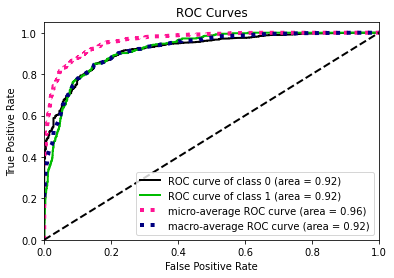

In [73]:
#Creamos el gráfico ROC mediantte umbralización de probabilidades de clases 
plot_roc(y_test, prob_test)

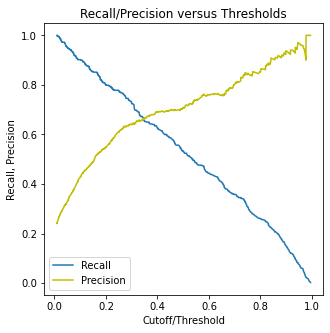

In [74]:
#Aunque nos pidieron en el ejercicio el ROC AUC, no es buen criterio en nuestro caso especial. ROC AUC tiene en cuenta la clase 
#negativa (0) y en datasets no balanceados como el nuestro la inclusión de clase negativa (mayoritaria según numero de observaciones)
#presenta resultado sobreoptimista.
#En nuestro caso mejor sería tener en cuenta el balance entre Recall (sensitivity) y Precision. 
#Intentamos predecir el máximo de clase positiva (sensitivity) pero al mismo tiempo intentando no perjudicar la precisión
#(no hay uso de total de clase negativa en el denominador en el cálculo de precisión)

precision,recall,thresholds=precision_recall_curve(y_test, prob_test[:,1])

metrics=pd.DataFrame(np.column_stack([precision[:-1],recall[:-1],thresholds]), columns=['Precision','Recall','Thresholds'])



plt.figure(figsize=(5,5))
plt.plot(metrics.Thresholds,metrics.Recall,  label='Recall')
plt.plot(metrics.Thresholds,metrics.Precision,  c='y', label='Precision')
plt.ylabel('Recall, Precision')
plt.xlabel('Cutoff/Threshold')
plt.title('Recall/Precision versus Thresholds')
plt.legend(loc=3)
plt.show()

In [75]:
#Elegiendo el cutoff en punto de cruce de precision y recall puede ser una opción. 

cutoff=metrics.loc[np.abs(metrics.Recall-metrics.Precision)==np.abs(metrics.Recall-metrics.Precision).min(),'Thresholds']

classes=np.where(prob_test[:,1]>=cutoff.values,1,0)

In [76]:
print(classification_report(y_test,classes))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2060
           1       0.66      0.66      0.66       397

    accuracy                           0.89      2457
   macro avg       0.80      0.80      0.80      2457
weighted avg       0.89      0.89      0.89      2457



<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

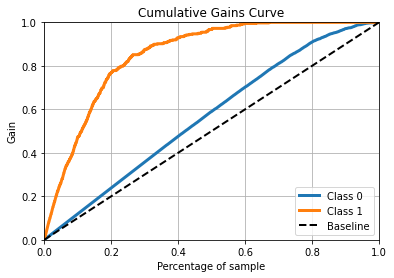

In [77]:
#También podemos decidir sobre el umbral de otra manera, teniendo en cuenta el Recall o maximizar casos positivos
#minimizando el tamaño de muestra. Por ejemplo si entre 10,000 nuevos clientes no clasificados queremos enviar campaña de
# marketing solo a 2000 (20%) podemos ubicar rl umbral en el percentil 80 (20% más altos en el vector de probabiilidades).
#Mediante el siguiente gráfico podemos ver que podremos conseguir más o menos 76% positivos desde el total de positivos en
#los 10000
plot_cumulative_gain(y_test, prob_test)

In [78]:
percentile=np.percentile(prob_test[:,1], 80)

classes=np.where(prob_test[:,1]>=percentile,1,0)

print(classification_report(y_test,classes))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2060
           1       0.62      0.77      0.69       397

    accuracy                           0.89      2457
   macro avg       0.79      0.84      0.81      2457
weighted avg       0.90      0.89      0.89      2457

